In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

import holidays

sns.set_style('whitegrid')

In [33]:
train = pd.read_csv("./train.csv", index_col=['date'], parse_dates=True)
test = pd.read_csv("./test.csv", index_col=['date'], parse_dates=True)
sample_submission = pd.read_csv("./sample_submission.csv")

train.drop(['id'],1,inplace=True)
test.drop(['id'],1,inplace=True)

In [516]:
train.head()

,country,store,product,num_sold
date,,,,
2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [59]:
train.shape, test.shape

((136950, 4), (27375, 3))

It seems to handle feature engineering

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 136950 entries, 2017-01-01 to 2021-12-31
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   country   136950 non-null  object
 1   store     136950 non-null  object
 2   product   136950 non-null  object
 3   num_sold  136950 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 5.2+ MB


In [61]:
train.describe()

,num_sold
count,136950.0000
mean,165.5226
std,183.6916
min,2.0000
25%,46.0000
50%,98.0000
75%,184.0000
max,1380.0000


In [62]:
train.isna().any().any()

False

In [63]:
df = pd.concat([train, test])
df[df.duplicated()]

,country,store,product,num_sold
date,,,,
2017-01-03,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,7.0000
2017-01-03,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,11.0000
2017-01-03,Canada,Kaggle Learn,Using LLMs to Win Friends and Influence People,26.0000
2017-01-03,Canada,Kaggle Learn,Using LLMs to Write Better,123.0000
2017-01-03,Canada,Kaggle Store,Using LLMs to Train More LLMs,240.0000
...,...,...,...,...
2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,NaN
2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,NaN
2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,NaN


# EDA

In [34]:
int_features = train.select_dtypes(exclude='object').columns.tolist()
cat_features = train.select_dtypes(include='object').columns.tolist()

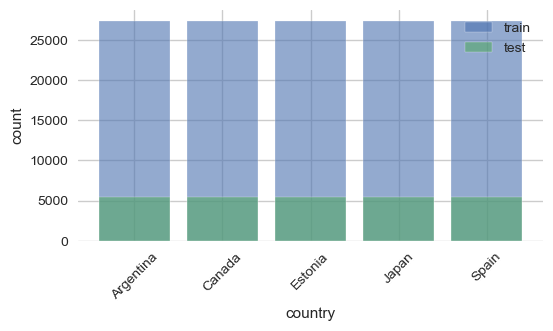

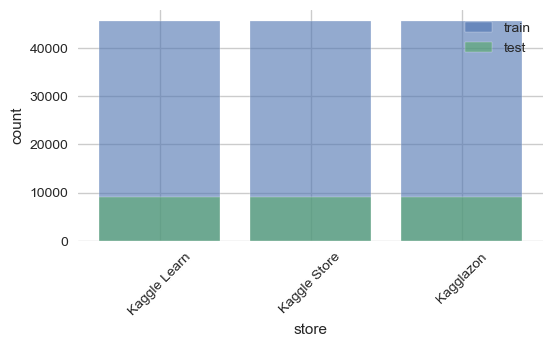

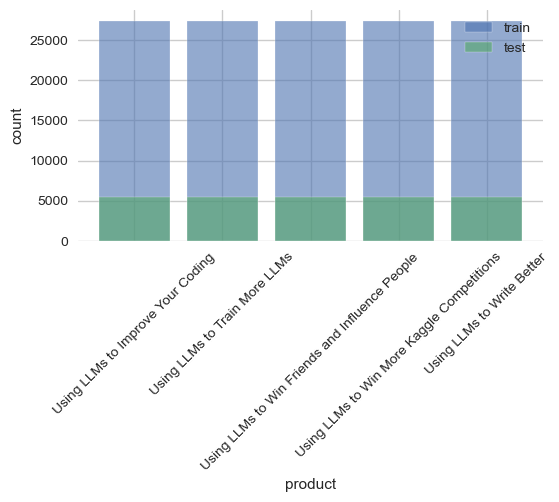

CPU times: user 977 ms, sys: 120 ms, total: 1.1 s
Wall time: 413 ms


In [68]:
%%time
for f in cat_features:
    plt.figure(figsize=(6,3))
    train_vc = train[f].value_counts()
    plt.bar(train_vc.index, train_vc, alpha=.6, label='train')
    test_vc = test[f].value_counts()
    plt.bar(test_vc.index, test_vc, alpha=.6, label='test')
    plt.legend()
    plt.xlabel(f)
    plt.xticks(rotation=45)
    plt.ylabel('count')
    plt.show()

## Target Variables

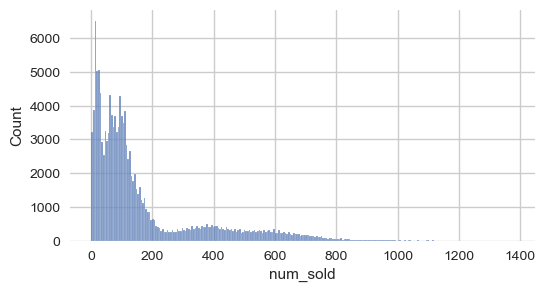

In [445]:
plt.figure(figsize=(6,3))
sns.histplot(train['num_sold'])
plt.show()

we need to log transform or scaling

## Independent Variables

<Figure size 800x550 with 0 Axes>

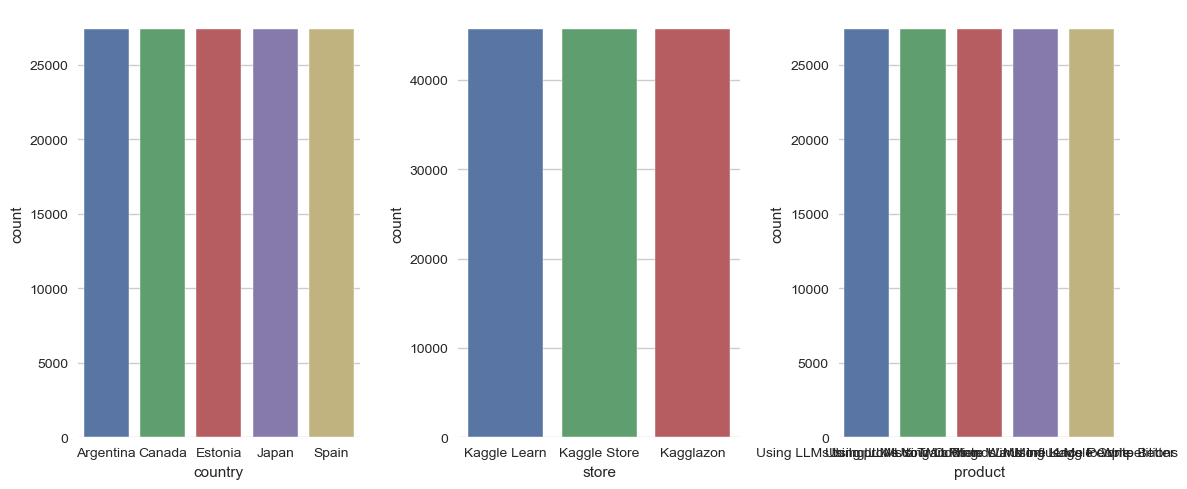

In [77]:
#cat features
def show_count_plot(data, columns, ax):
    i = 0
    plt.figure()
    plt.subplots(ax, math.ceil(len(columns)/ax), figsize=(12,5))
    for col in columns:
        i += 1
        plt.subplot(ax, math.ceil(len(columns)/ax), i)
        sns.countplot(data[col])
        plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


show_count_plot(train, cat_features, 1)

<Figure size 800x550 with 0 Axes>

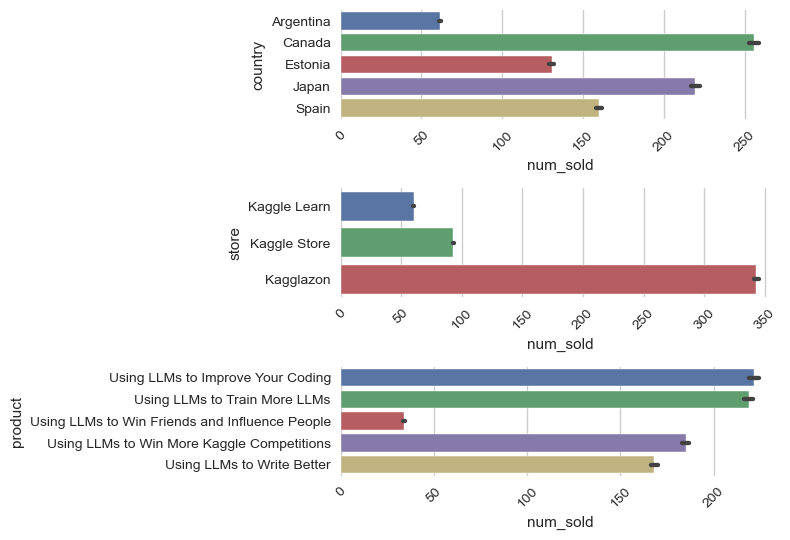

In [85]:
#cat features
def show_bar_plot(data, columns, ax):
    i = 0
    plt.figure()
    plt.subplots(ax, math.ceil(len(columns)/ax))
    for col in columns:
        i += 1
        plt.subplot(ax, math.ceil(len(columns)/ax), i)
        sns.barplot(data=data, y=col, x='num_sold')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

show_bar_plot(train, cat_features, 3)

Canada 지역에서 많이 팔렸으며 kagglazon 지점에서 많은 구매, 친구 및 인플루언서 경쟁에서 이기기 위해서 LLMs를 사용하지 않음.  
코딩 실력을 늘리고 좀 더 훈련을 시키며 캐글 컴피티션과 더 잘하기 위해서 구매함.

## Time series

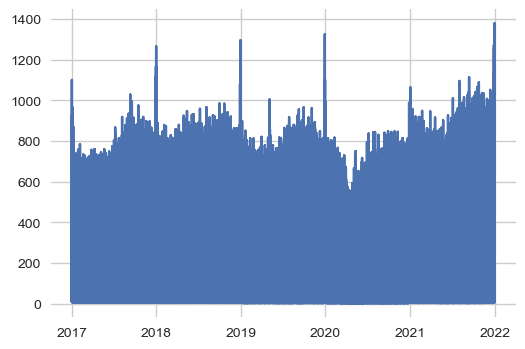

In [458]:
plt.figure(figsize=(6,4))
plt.plot(train['num_sold'])
plt.show()

주기를 가지고 있는데, 2020년 이후 코로나인가?

In [35]:
def create_features(df_temp):
    df_temp.index = pd.to_datetime(df_temp.index)
    df_temp['month'] = df_temp.index.month
    df_temp['day'] = df_temp.index.day
    df_temp['year'] = df_temp.index.year
    df_temp['dayofweek'] = df_temp.index.dayofweek
    df_temp['quarter'] = df_temp.index.quarter
    df_temp['dayofmonth'] = df_temp.index.day
    df_temp['weekofyear'] = df_temp.index.weekofyear
    df_temp['sunday'] = (df_temp['dayofweek'] == 6).astype(int)
    df_temp['december'] = (df_temp['weekofyear'] == 6).astype(int)
    return df_temp

train = create_features(train)
test = create_features(test)

In [36]:
def get_holidays(df):
    years_list = [2017, 2018, 2019, 2020, 2021, 2022]

    holiday_BE = holidays.CountryHoliday('BE', years = years_list)
    holiday_FR = holidays.CountryHoliday('FR', years = years_list)
    holiday_DE = holidays.CountryHoliday('DE', years = years_list)
    holiday_IT = holidays.CountryHoliday('IT', years = years_list)
    holiday_PL = holidays.CountryHoliday('PL', years = years_list)
    holiday_ES = holidays.CountryHoliday('ES', years = years_list)

    holiday_dict = holiday_BE.copy()
    holiday_dict.update(holiday_FR)
    holiday_dict.update(holiday_DE)
    holiday_dict.update(holiday_IT)
    holiday_dict.update(holiday_PL)
    holiday_dict.update(holiday_ES)

    df['holiday_name'] = df.index.map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    df = df.drop(columns=["holiday_name"])
    
    return df

train = get_holidays(train)
test = get_holidays(test)

In [37]:
#time seires weighted
train[(train.index >= '2020-04-01') & (train.index <= '2020-04-30')]['num_sold'] = train[(train.index >= '2020-04-01') & (train.index <= '2020-04-30')]['num_sold'] * 1.1

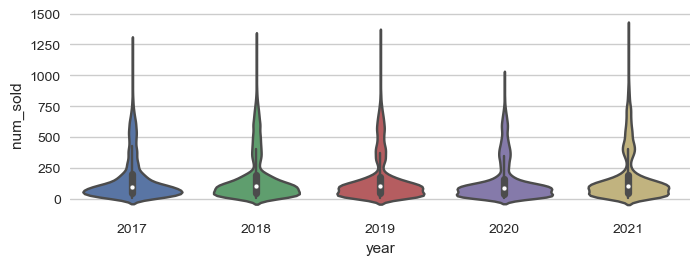

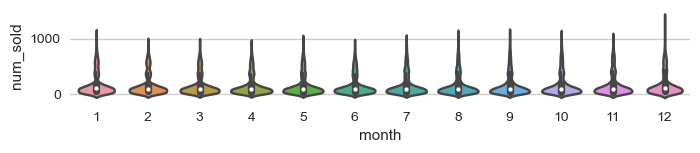

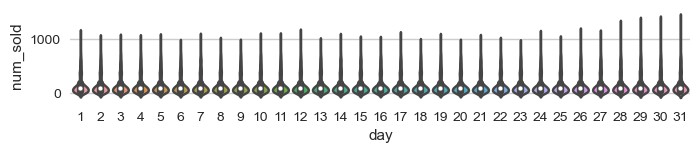

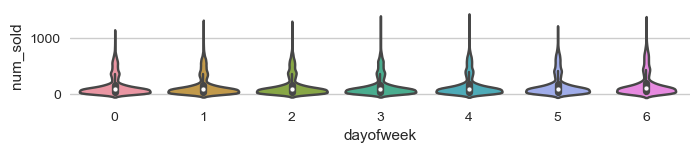

In [8]:
plt.figure(figsize=(8,12))
plt.subplot(4,1,1)
sns.violinplot(data=train, x='year',y='num_sold')
plt.show()

plt.subplot(4,1,2)
sns.violinplot(data=train, x='month',y='num_sold')
plt.show()

plt.subplot(4,1,3)
sns.violinplot(data=train, x='day',y='num_sold')
plt.show()

plt.subplot(4,1,4)
sns.violinplot(data=train, x='dayofweek',y='num_sold')
plt.show()

2020년에 구매가 가장 적었고, 11월부터 1월까지는 증가하는 것을 확인할 수 있다.
이는 신년 목표를 세운 것으로 판단된다. 8~10월은 왜 상승했을까? 29 ~31일에 상승하는 이유는?

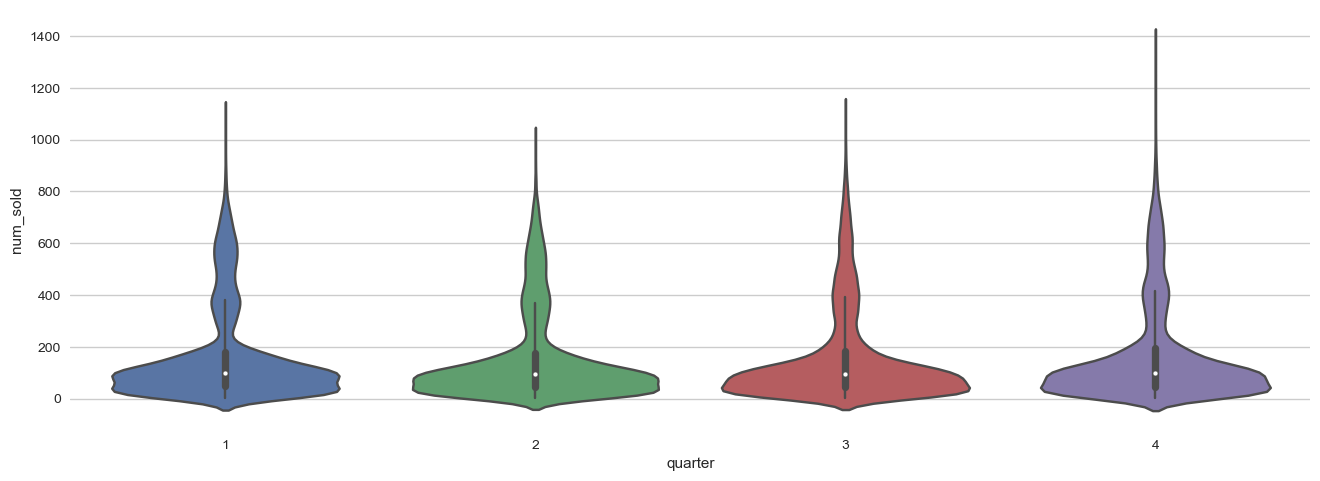

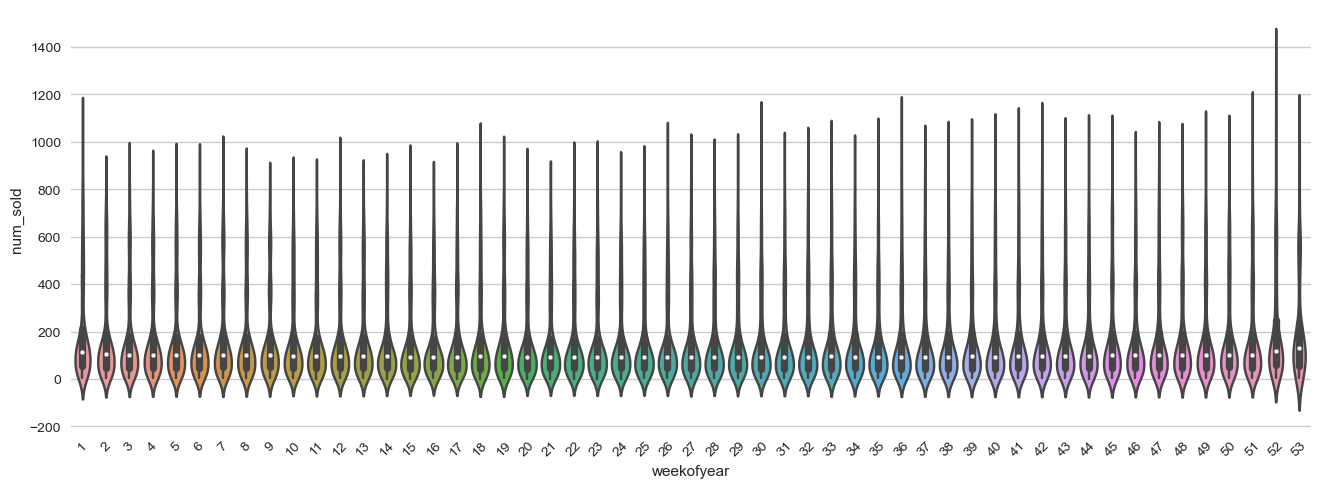

In [403]:
plt.figure(figsize=(16,12))
plt.subplot(2,1,1)
sns.violinplot(data=train, x='quarter',y='num_sold')
plt.show()

plt.figure(figsize=(16,12))
plt.subplot(2,1,2)
sns.violinplot(data=train, x='weekofyear',y='num_sold')
plt.xticks(rotation=45)
plt.show()

<AxesSubplot:xlabel='store', ylabel='num_sold'>

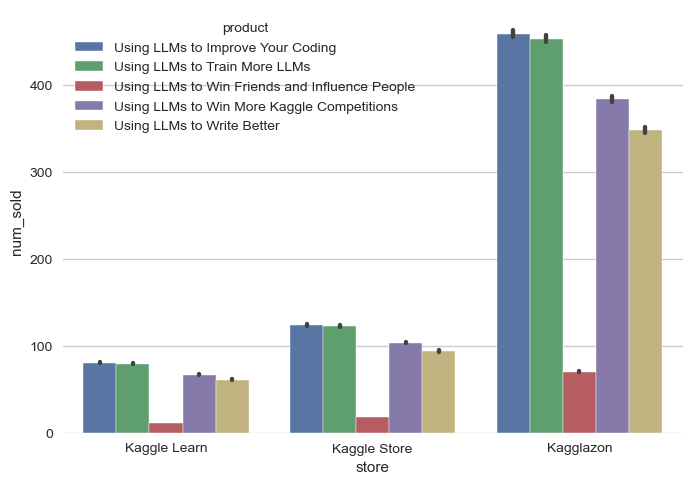

In [126]:
sns.barplot(data=train, x='store',y='num_sold',hue='product')

# Feature engineering

In [38]:
# #covid = '2020-03-12'
train['covid'] = 0
train['covid'] = np.where(train.index >= pd.to_datetime('2020-03-12'), 1, 0)

test['covid'] = 0
test['covid'] = np.where(test.index >= pd.to_datetime('2020-03-12'), 1, 0)

#(cos, sin)
train['cos_day'] = np.cos(2 * np.pi * train['day'] / 365)
train['sin_day'] = np.sin(2 * np.pi * train['day'] / 365)
train['cos_month'] = np.cos(2 * np.pi * train['month'] / 12)
train['sin_month'] = np.sin(2 * np.pi * train['month'] / 12)

test['cos_day'] = np.cos(2 * np.pi * test['day'] / 365)
test['sin_day'] = np.sin(2 * np.pi * test['day'] / 365)
test['cos_month'] = np.cos(2 * np.pi * test['month'] / 12)
test['sin_month'] = np.sin(2 * np.pi * test['month'] / 12)

<AxesSubplot:>

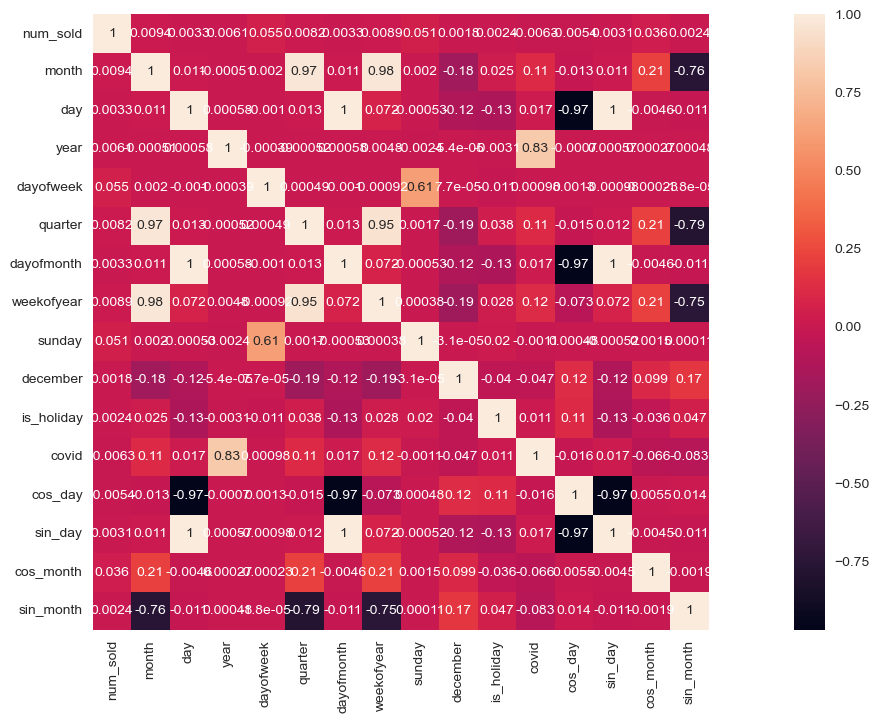

In [39]:
plt.figure(figsize=(22,8))
sns.heatmap(train.corr(), annot=True, square=True)

# Modeling

In [40]:
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor,BaggingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, SplineTransformer
from sklearn.metrics import mean_absolute_error

In [11]:
# train['num_sold'] = np.log1p(train['num_sold'])

In [41]:
X = train.drop(['num_sold'],1)
y = train['num_sold']

tscv = TimeSeriesSplit(n_splits=4)
scores = []
test_preds_res = []
test_preds = np.zeros(len(test))
for fold, (train_idx, test_idx) in enumerate(tscv.split(X,y)):
    X_train,X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train,y_test = y.iloc[train_idx], y.iloc[test_idx]    

In [42]:
#one hot encoder
from feature_engine.encoding import OneHotEncoder
encoder = OneHotEncoder(variables=cat_features)
X_train_transformed = encoder.fit_transform(X_train)
X_test_transformed = encoder.transform(X_test)

# encoder = LabelEncoder()
# for col in cat_features:
#     X_train[col] = encoder.fit_transform(X_train[col])
#     X_test[col] = encoder.transform(X_test[col])
#     train[col] = encoder.transform(train[col])
#     test[col] = encoder.transform(test[col])

In [43]:
#model
model = CatBoostRegressor(n_estimators=1000, cat_features=cat_features, 
                          learning_rate=0.099, max_bin=64, max_depth=3, 
                          allow_writing_files=False, eval_metric="MAPE", random_seed=0, silent=True)

model.fit(X_train,y_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [44]:
pred = model.predict(X_test)

In [46]:
# SMAPE metriği
def smape(y_true, y_pred):
    return 1 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)) * 100)

smape(y_test, pred)

31.191779611228547

In [53]:
%%time
target = 'num_sold'
original_features = test.columns

result_list = []
def score_model(model, features_used, label=None):
    score_list = []
    oof = np.zeros_like(train[target])
    tscv = TimeSeriesSplit(n_splits=4)
    for fold, (idx_tr, idx_val) in enumerate(tscv.split(train[original_features], train[target])):
        X_train = train.iloc[idx_tr][features_used]
        X_valid = train.iloc[idx_val][features_used]
        y_train = train.iloc[idx_tr][target]
        y_valid = train.iloc[idx_val][target]
        
        from feature_engine.encoding import OneHotEncoder
        encoder = OneHotEncoder(variables=cat_features)
        X_train = encoder.fit_transform(X_train)
        X_valid = encoder.transform(X_valid)
    
        model.fit(X_train, y_train)
        tscore = smape(y_train, model.predict(X_train))
        y_valid_pred = model.predict(X_valid)
        score = smape(y_valid, y_valid_pred)
        print(f" Fold {fold} : tscore = {tscore:.3f} score = {score:.3f}")
        oof[idx_val] = y_valid_pred
        score_list.append(score)
        
    score = sum(score_list) / len(score_list)
    print(f" Avg. smape score : {score:.3f}")
    if label is not None:
        global result_list
        result_list.append((label, score, oof))

score_model(CatBoostRegressor(n_estimators=1000, 
                          learning_rate=0.099, max_bin=64, max_depth=3, 
                          allow_writing_files=False, eval_metric="MAPE", random_seed=0, silent=True), features_used=test.columns, label="Cat")

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

 Fold 0 : tscore = 15.849 score = 26.464
 Fold 1 : tscore = 16.688 score = 19.706
 Fold 2 : tscore = 17.502 score = 26.556
 Fold 3 : tscore = 20.148 score = 37.160
 Avg. smape score : 27.472
CPU times: user 1min 17s, sys: 16 s, total: 1min 33s
Wall time: 19.9 s


# final model

In [65]:
X_train = train.drop(['num_sold'],1)
y_train = train['num_sold']

In [67]:
encoder = OneHotEncoder(variables=cat_features)
X_train = encoder.fit_transform(X_train)
test = encoder.transform(test)

In [68]:
model = CatBoostRegressor(n_estimators=1000,
                          learning_rate=0.099, max_bin=64, max_depth=3, 
                          allow_writing_files=False, eval_metric="MAPE", random_seed=0, silent=True)
model.fit(X_train,y_train)

In [77]:
sample_submission['num_sold'] = model.predict(test)
sample_submission['num_sold'] = sample_submission['num_sold'].clip(0)

(array([1.3631e+04, 7.2580e+03, 1.0570e+03, 1.7980e+03, 1.3610e+03,
        1.1720e+03, 7.8300e+02, 2.7600e+02, 3.1000e+01, 8.0000e+00]),
 array([   0.        ,  108.24762069,  216.49524138,  324.74286207,
         432.99048276,  541.23810345,  649.48572413,  757.73334482,
         865.98096551,  974.2285862 , 1082.47620689]),
 <BarContainer object of 10 artists>)

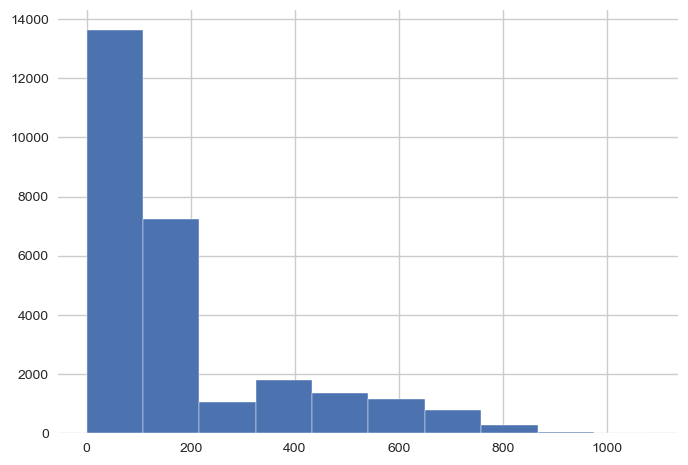

In [78]:
plt.hist(sample_submission['num_sold'])

In [79]:
sample_submission.to_csv("./baseline_tscv_all_train_parameters.csv",index=False)